In [3]:
import numpy as np
import scipy.linalg as linalg
import scipy.sparse as sparse
from scipy.sparse.linalg import splu

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from numba import jit
import os
import time

def Contour_Zeros(Calque):
    """
    Return a numpy array of the same dimension of the 2D array Calque containing 1 on the contour of Calque and 0 elsewhere
    """
    Contour = np.ones(np.shape(Calque))
    Difference_X = (Calque[1:,:] == Calque[:-1,:])
    Difference_Y = (Calque[:,1:] == Calque[:,:-1])
    Contour[:-1,:] *= Difference_X
    Contour[1:,:] *= Difference_X
    Contour[:,:-1] *= Difference_Y
    Contour[:,1:] *= Difference_Y    
    return ((Contour==0)*Calque)==0

# Parameters

In [ ]:
# REYNOLDS NUMBER
Re = 100

#FPS
fps = 60

# Space & Spatial Operators

In [11]:
#SPACE
radius = 1/2
Lx = 8*radius*2
Ly = 4*radius*2

Nx = np.int64(Lx*10*int(np.sqrt(Re)+1))
Ny = np.int64(Ly*10*int(np.sqrt(Re)+1))
center_x = 1
center_y = Ly/2

Delta_x = Lx/Nx
Delta_y = Ly/Ny

List_coordinate = np.meshgrid(np.arange(Nx)*Delta_x,np.arange(Ny)*Delta_y)
List_r = np.sqrt((List_coordinate[1] - center_y)**2 + (List_coordinate[0] - center_x)**2)
List_theta = np.arctan2((List_coordinate[1] - center_y),(List_coordinate[0] - center_x))
Layer = ((List_coordinate[0] - center_x)/(Delta_y/Delta_x))**2 + (List_coordinate[1] - center_y)**2 >= radius**2
Contour = Contour_Zeros(Layer)
Obstacle = Contour*Layer

#Boundary Conditions

def u_all(u_int):
    u = np.ones((Ny,Nx)) #Dirichlet 1 at the entrance
    u[1:-1,1:-1] = u_int
    u[:,-1] = u[:,-2] #Neumann 0 at the exit
    u[0,:]  = u[1,:]  #Neumann 0 at the bottom
    u[-1,:] = u[-2,:] #Neumann 0 at the top

    return u*Obstacle # Dirichlet 0 on the obstacle

def v_all(v_int):
    v = np.zeros((Ny,Nx)) #Dirichet 0 at the entrance
    v[1:-1,1:-1] = v_int
    v[:,-1] = v[:,-2] #Neumann 0 at the exit
    v[0,:]  = v[1,:]  #Neumann 0 at the bottom
    v[-1,:] = v[-2,:] #Neumann 0 at the top
        
    return v*Obstacle #Dirichlet 0 on the obstacle
    
def Pressure_all(P_int):
    P = np.zeros((Ny,Nx))
    P[1:-1,1:-1] = P_int
    P[:,0]  = P[:,1]  #Neumann 0 at the entrance
    P[:,-1] = P[:,-2] #Neumann 0 at the exit
    P[0,:]  = P[1,:]  #Neumann 0 at the bottom
    P[-1,:] = P[-2,:] #Neumann 0 at the top
    
    return P

# Operators

def dx(f):
    """
    First x derivative on the interior
    """
    return (f[1:-1,2:]-f[1:-1,:-2])/(2*Delta_x)

def dy(f):
    """
    First x derivative on the interior
    """
    return (f[2:,1:-1]-f[:-2,1:-1])/(2*Delta_y)

def dxx(f):
    """
    Second x derivative on the interior
    """
    return (f[1:-1,2:]-2*f[1:-1,1:-1]+f[1:-1,:-2])/Delta_x**2

def dyy(f):
    """
    Second y derivative on the interior
    """
    return (f[2:,1:-1]-2*f[1:-1,1:-1]+f[:-2,1:-1])/Delta_y**2
    
def div(fx,fy):
    """
    Divergence on the whole domain
    """
    dx = np.zeros((Ny,Nx)) #Neumann 0 at the exit
    dx[:,1:-1] = (fx[:,2:]-fx[:,:-2])
    dx[:,0] = (fx[:,1]-1)  #Dirichlet 1 at the entrance (making the assumption that u = 1 before the entrance)
    
    dy = np.zeros((Ny,Nx)) #Neumann 0 at the bottom and at the top
    dy[1:-1,:] = (fy[2:,:]-fy[:-2,:])
        
    return dx/(2*Delta_x)+dy/(2*Delta_y)
    
def rot(fx,fy):
    """
    Rotationnal on the interior
    """
    return dx(fy)-dy(fx)

def laplacian(f):
    """
    Laplacian on the interior
    """
    return dxx(f)+dyy(f)

def laplacian_matrix(Nx=Nx,Ny=Ny):
    I_Nx = np.ones(Nx)
    Ex_mid = -2*I_Nx
    Ex_mid[-1] += 1
    Ex_up_diag = np.ones(Nx)
    Ex_up_diag[-1] = 0
    Lapla_X_up_diag = np.kron(np.ones(Ny),Ex_up_diag)[:-1]
    Lapla_X = sparse.diags(
        [np.kron(np.ones(Ny),Ex_mid), Lapla_X_up_diag, Lapla_X_up_diag], offsets=[0,1,-1])*Nx**2
    
    Lapla_Y_diag_calque = -2*np.ones(Ny)
    Lapla_Y_diag_calque[0] += 1
    Lapla_Y_diag_calque[-1] += 1
    Lapla_Y = sparse.diags(
        [np.kron(Lapla_Y_diag_calque,I_Nx), np.ones((Ny-1)*Nx), np.ones((Ny-1)*Nx)], offsets=[0,Nx,-Nx])*Ny**2
    
    return Lapla_Y + Lapla_X

# Initial Conditions

def Initial():
    """
    Return the analytic solution of the laminar flow (for a potential/irrotationnal flow)
    """
    #Velocity in polar coordinates
    List_ur = np.cos(List_theta)*(1-(radius/List_r)**2)
    List_ut = -np.sin(List_theta)*(1+(radius/List_r)**2)
    
    #Velocity in cartesian coordinates
    List_ux = List_ur*np.cos(List_theta) - List_ut*np.sin(List_theta)
    List_uy = List_ur*np.sin(List_theta) + List_ut*np.cos(List_theta)
    
    #Pressure
    List_P = 1/2*(1 - List_ur**2 - List_ut**2)
    
    List_Ini = np.array([List_ux, List_uy, List_P])
    
    List_Ini[np.isnan(List_Ini)] = 0 #Dividing by 0 at r = 0
    
    return List_Ini*Layer


In [12]:
Inverse_Laplacian = splu(laplacian_matrix())
print('Matrix Built')

C:\Users\bjona\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


Matrix Built


# Simulation Functions

In [13]:
@jit
def iterate(u_previous,v_previous,t_previous):
    #Time
    Delta_t = np.min([Re/(2/Delta_x**2+2/Delta_y**2),
                    Delta_x/(1/(Re*Delta_x)+np.max(np.abs(u_previous))),
                    Delta_y/(1/(Re*Delta_y)+np.max(np.abs(v_previous)))])/5
    
    #u*

    u_star_int = u_previous[1:-1,1:-1] + Delta_t*(
        1/Re*laplacian(u_previous)
        -( u_previous[1:-1,1:-1]*dx(u_previous)
        +  v_previous[1:-1,1:-1]*dy(u_previous)))
    v_star_int = v_previous[1:-1,1:-1] + Delta_t*(
        1/Re*laplacian(v_previous)
        -( u_previous[1:-1,1:-1]*dx(v_previous)
        +  v_previous[1:-1,1:-1]*dy(v_previous)))
    
    u_star = u_all(u_star_int)
    v_star = v_all(v_star_int)

    #P

    P = np.reshape(
            Inverse_Laplacian.solve(
                np.reshape(
                    div(u_star,v_star),(1,Nx*Ny)
                )[0]
            ),(Ny,Nx))

    #u

    u_int = u_star[1:-1,1:-1] - dx(P)    
    v_int = v_star[1:-1,1:-1] - dy(P)
    
    u = u_all(u_int)
    v = v_all(v_int)
    
    return u,v,P,t_previous+Delta_t

C:\Users\bjona\AppData\Local\Temp\ipykernel_5952\4250885185.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterate(u_previous,v_previous,t_previous):


In [18]:
def get_steady_state(show=True):
    fname = f'Lx{Lx:.0f}_Ly{Ly:.0f}_Re{Re}_0.npy'
    if fname in os.listdir() :
        raise Exception(f"Steady State at Re = {Re} already computed ('{fname}')")
    
    List_V = Initial()
    Previous_velocity_x = List_V[0]
    Previous_velocity_y = List_V[1]
    t = 0
    i = 0
    real_time_0 = time.time()
    while t < Lx :
        i += 1
        Previous_velocity_x,Previous_velocity_y,P,t = iterate(Previous_velocity_x,Previous_velocity_y,t)
        if i%1000 == 0:
            real_time = time.time() - real_time_0
            print(f'Elapsed {real_time:.0f} s,\t Progression : {t/Ly*100:.0f}%')
    
    if show:
        xi,xf = 0,-1#200,360
        yi,yf = -1,0#200,280
        extent = [0, Lx, -Ly/2, Ly/2]

        fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (20,20))

        plot1 = List_grid_velocity_x[timestep][yi:yf:-1,xi:xf]
        im1 = ax[0].imshow(plot1,extent=extent,cmap=mpl.colormaps['seismic'])
        ax[0].set(title=r'$u_x$')
        cax = fig.add_axes([ax[0].get_position().x1+0.02,ax[0].get_position().y0,0.05,ax[0].get_position().height])
        plt.colorbar(im1, cax=cax,shrink=0.5)
        m1 = np.max(np.abs(np.float64(plot1)))
        im1.set_clim(-m1,m1)

        plot2 = List_grid_velocity_y[timestep][yi:yf:-1,xi:xf]
        im2 = ax[1].imshow(plot2,extent=extent,cmap=mpl.colormaps['seismic'])
        ax[1].set(title=r'$u_y$')
        cax = fig.add_axes([ax[1].get_position().x1+0.02,ax[1].get_position().y0,0.05,ax[1].get_position().height])
        plt.colorbar(im2, cax=cax,shrink=0.5)
        m2 = np.max(np.abs(np.float64(plot2)))
        im2.set_clim(-m2,m2)

    
    np.save(fname,np.array([[Previous_velocity_x],[Previous_velocity_y]]))
    print(f'Saved as {fname}')

In [ ]:
def find_file(params):
    len_params = len(params)
    List_good_files = []
    for file in os.listdir():
        if file[:len_params] == params:
            List_good_files.append(file)
    
    if List_good_files == []:
        print('Run never done before. Computing Steady State.')
        get_steady_state(show=False)
        file_ini = params+'_0.npy'
        nb_iter_old = 0

    else :
        nb_iter_done = [int(file.split('.')[0].split('_')[-1]) for file in List_good_files]
        index = np.argmax(nb_iter_done)
        file_ini = List_good_files[index]
        nb_iter_old = nb_iter_done[index]
        
    return file_ini, nb_iter_old

def run(nb_iter=10000):
    params = f'Lx{Lx:.0f}_Ly{Ly:.0f}_Re{Re}'
    
    file_ini, nb_iter_old = find_file(params)
    
    [Previous_velocity_x,Previous_velocity_y] = np.load(file_ini)[:,-1]
    
    if nb_iter_old == 0:
        random_noise = 0.1 * (np.random.random((Ny,Nx))*2-1)

        noise_x = div(np.zeros((Ny,Nx)),random_noise)
        noise_y = -div(random_noise,np.zeros((Ny,Nx)))

        Previous_velocity_x += noise_x
        Previous_velocity_y += noise_y
        
    t_loc = 0
    List_grid_velocity_x = [Previous_velocity_x]
    List_grid_velocity_y = [Previous_velocity_y]

    real_time_0 = time.time()
    for i in range(nb_iter) : #if t_loc > t_window :
        Previous_velocity_x,Previous_velocity_y,P,dt = iterate(Previous_velocity_x,Previous_velocity_y,0)
        t_loc += dt
        if t_loc > 1/fps:
            t_loc -= 1/fps
            real_time = time.time() - real_time_0
            List_grid_velocity_x.append(Previous_velocity_x)
            List_grid_velocity_y.append(Previous_velocity_y)
            print(f'Elapsed {real_time:.0f} s,\t Progression : {t/Ly*100:.0f}%')
    
    nb_iter_new = int(nb_iter + nb_iter_old)
    
    fname = params+f'_{nb_iter_new}.npy'
    np.save(fname,np.array([List_grid_velocity_x,List_grid_velocity_y]))
    print('Saved')

# Runs

In [ ]:
run(nb_iter=10000)

## Plots

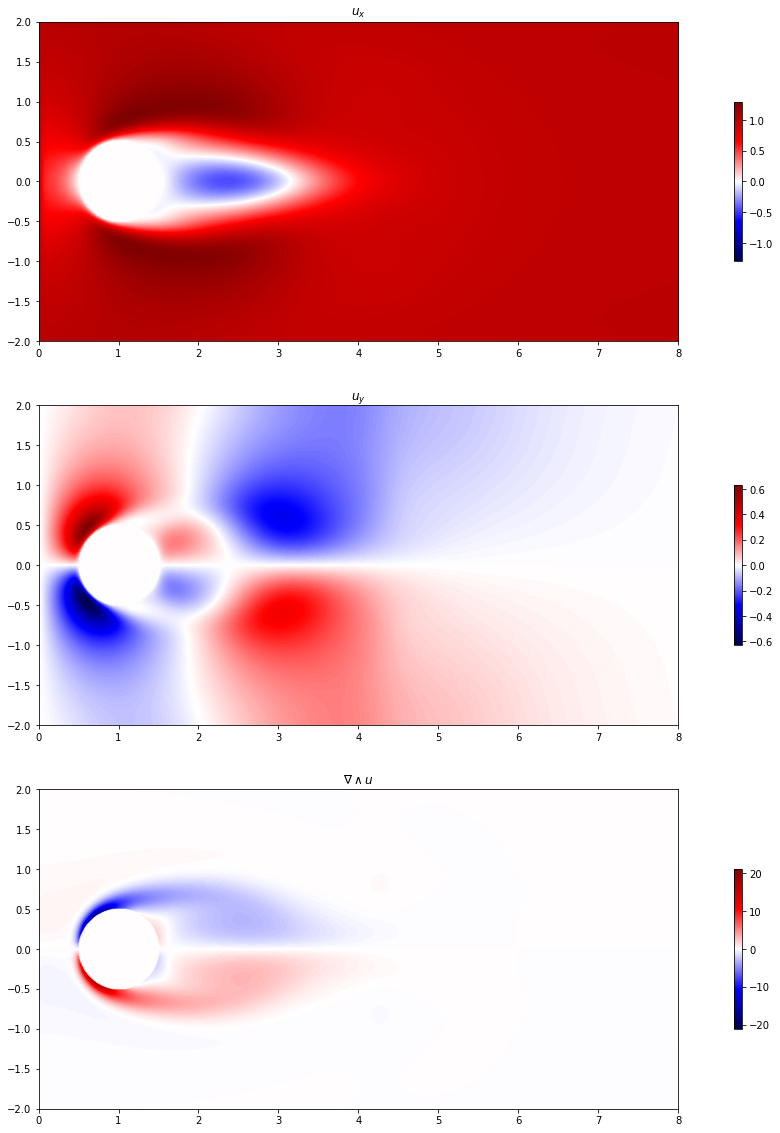

In [11]:
timestep = -1

xi,xf = 0,-1#200,360
yi,yf = -1,0#200,280
extent = [0, Lx, -Ly/2, Ly/2]

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (20,20))

plot1 = List_grid_velocity_x[timestep][yi:yf:-1,xi:xf]
im1 = ax[0].imshow(plot1,extent=extent,cmap=mpl.colormaps['seismic'])
ax[0].set(title=r'$u_x$')
plt.colorbar(im1, ax=ax[0],shrink=0.5)
m1 = np.max(np.abs(np.float64(plot1)))
im1.set_clim(-m1,m1)

plot2 = List_grid_velocity_y[timestep][yi:yf:-1,xi:xf]
im2 = ax[1].imshow(plot2,extent=extent,cmap=mpl.colormaps['seismic'])
ax[1].set(title=r'$u_y$')
plt.colorbar(im2, ax=ax[1],shrink=0.5)
m2 = np.max(np.abs(np.float64(plot2)))
im2.set_clim(-m2,m2)

plot3 = rot(List_grid_velocity_x[timestep],List_grid_velocity_y[timestep])[yi:yf:-1,xi:xf]
#plot3 = (List_grid_pressure[timestep][yi:yf:-1,xi:xf])
im3 = ax[2].imshow(plot3,extent=extent,cmap=mpl.colormaps['seismic'])
ax[2].set(title=r'$\nabla \wedge u$')
plt.colorbar(im3, ax=ax[2],shrink=0.5)
m3 = np.max(np.abs(np.float64(plot3)))
im3.set_clim(-m3,m3)

plt.show()

# Animation

MovieWriter ffmpeg unavailable; using Pillow instead.


..Done!
.

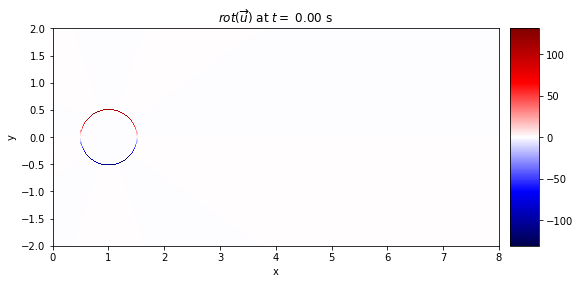

In [18]:
fps = 60
nSeconds = len(List_grid_velocity_y)//fps
snapshots = [rot(List_grid_velocity_x[i],List_grid_velocity_y[i]) 
            for i in range(len(List_grid_velocity_x))]#[ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]
M = np.max(np.array(snapshots))

# First set up the figure, the axis, and the plot element we want to animate
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(Lx,Ly) )

a = snapshots[0]
m = np.max(np.abs(np.float64(snapshots)))
im = ax.imshow(a, interpolation='none', aspect='auto', vmin=-m, vmax=m,
                extent=[0, Lx, -Ly/2, Ly/2],
                cmap=mpl.colormaps['seismic'])
ax.set(xlabel='x', ylabel='y')
ax.set(title=r'$rot(\overrightarrow{u})$ at $t = 0$ s')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.05,ax.get_position().height])
plt.colorbar(im,cax=cax)
im.set_clim(-M,M)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    ax.set(title=r'$rot(\overrightarrow{u})$ at $t =$'+f' {List_Time[i]:.2f} s')
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('test_anim_clean.gif', fps=fps)


print('Done!')